In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit

def c_and_cprime(t, pars):
    c = pars['c0'] * np.exp(-pars['gamma'] * t)
    cp = -pars['gamma'] * pars['c0'] * np.exp(-pars['gamma'] * t)
    return c, cp

def solve_p(p0, F, h, pars):
    p = p0.copy()
    eps_reg = 1e-5
    # First RK4 step (g1)
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g1 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Second RK4 step (g2)
    p = p0 + 0.5 * h * g1
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g2 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Third RK4 step (g3)
    p = p0 + 0.5 * h * g2
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g3 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Fourth RK4 step (g4)
    p = p0 + h * g3
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g4 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Final RK4 update for p1
    p1 = p0 + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
    return p1

def kd_step(x, p, h, pars, Force):
    x = x + 0.5 * h * p
    F = Force(x)
    p = solve_p(p, F, h, pars)
    x = x + 0.5 * h * p
    return x, p

def hd_step(x, p, h, pars, Force):
    gamma = pars['gamma']
    delta = 1/(1 + gamma * h)
    p = delta * p + h * delta * Force(x)
    x = x + h * p
    return x, p

def gd_step(x, p, h, pars, Force):
    x = x + h * Force(x)
    return x, p

def plot_diagnostics_2D(Q,P,T,U,potential_lambda,c_0,gamma,lim=3):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q[:, 0], Q[:, 1], lw=1.5, color = 'yellow')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(T, U)
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')
    if c_0 != 0:
        axs[1][1].plot(T, c_0 * np.exp(-gamma * T), color = 'green', label = 'Desired KE')
    axs[1][1].plot(T, 0.5 * np.linalg.norm(P, axis=1)**2, label = 'KE')
    #axs[1][1].plot(T, U, label = 'PE')
    #axs[1][1].plot(T, U + 0.5 * np.linalg.norm(P, axis=1)**2, color = 'black', label = 'Hamiltonian')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')

    axs[1][0].semilogy(T, U) 
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compare(Q,P,T,U,potential_lambda,lim=3):
    Q_kd, Q_hd = Q
    P_kd, P_hd = P
    U_kd, U_hd = U

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q_kd[:, 0], Q_kd[:, 1], lw=1.5, color = 'yellow', label = 'KD')
    _, = axs[0][0].plot(Q_hd[:, 0], Q_hd[:, 1], lw=1.5, color = 'orange', label = 'HD')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][0].legend()
    axs[0][1].plot(T, U_kd, label = 'KD')
    axs[0][1].plot(T, U_hd, label = 'HD')
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')
    axs[0][1].legend()

    axs[1][1].plot(T, 0.5 * np.linalg.norm(P_kd, axis=1)**2, label = 'KD')
    axs[1][1].plot(T, 0.5 * np.linalg.norm(P_hd, axis=1)**2, label = 'HD')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')
    axs[1][1].legend()

    axs[1][0].semilogy(T, U_kd, label = 'KD')
    axs[1][0].semilogy(T, U_hd, label = 'HD')
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    axs[1][0].legend()
    plt.tight_layout()
    plt.show()

In [242]:
pars = {
    'c0': 1.,
    'gamma': 0.9
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
K = [1]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * (1 * x[0]**2 + 1 * x[1]**2)
Force_HO = lambda x: np.array([-1 * x[0], -x[1]])
U = [U_HO(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (1 * X**2 + 1 * Y**2)
#plot_diagnostics_2D(Q_kd,P_kd,T,U_kd,potential_lambda,pars['c0'],pars['gamma'],lim=3)

In [247]:
pars = {
    'gamma': 0.9,
    'c0': 0
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_HO(q)]
for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (1 * X**2 + 1 * Y**2)
#plot_diagnostics_2D(Q_hd,P_hd,T,U_hd,potential_lambda,pars['c0'],pars['gamma'],lim=3)

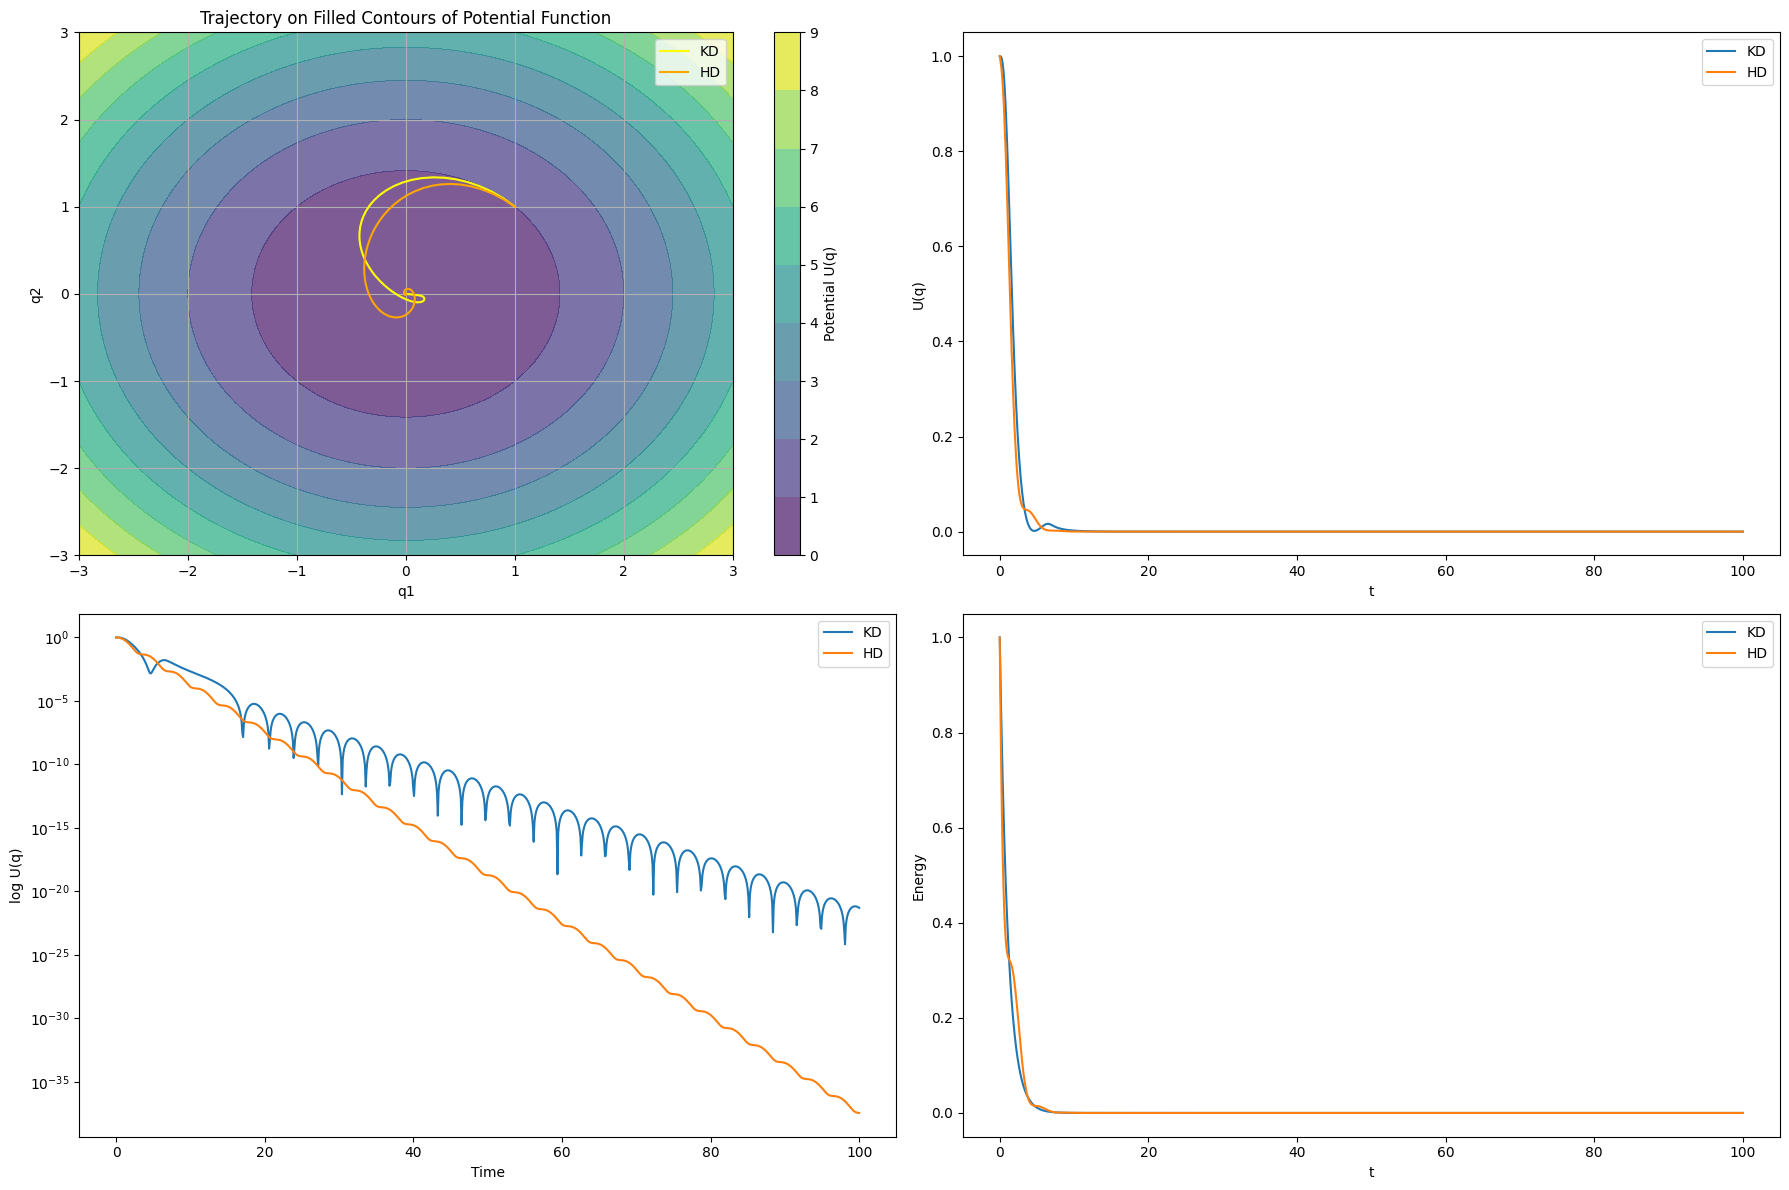

In [248]:
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# 2D Correlated Quadratic Function

In [285]:
pars = {
    'c0': 1.,
    'gamma': 0.9
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
K = [1]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * (10 * x[0]**2 + 1 * x[1]**2)
Force_HO = lambda x: np.array([-10 * x[0], -x[1]])
U = [U_HO(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (10 * X**2 + 1 * Y**2)
#plot_diagnostics_2D(Q_kd,P_kd,T,U_kd,potential_lambda,pars['c0'],pars['gamma'],lim=3)

In [286]:
pars = {
    'gamma': 0.9,
    'c0': 0
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_HO(q)]
for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (10 * X**2 + 1 * Y**2)

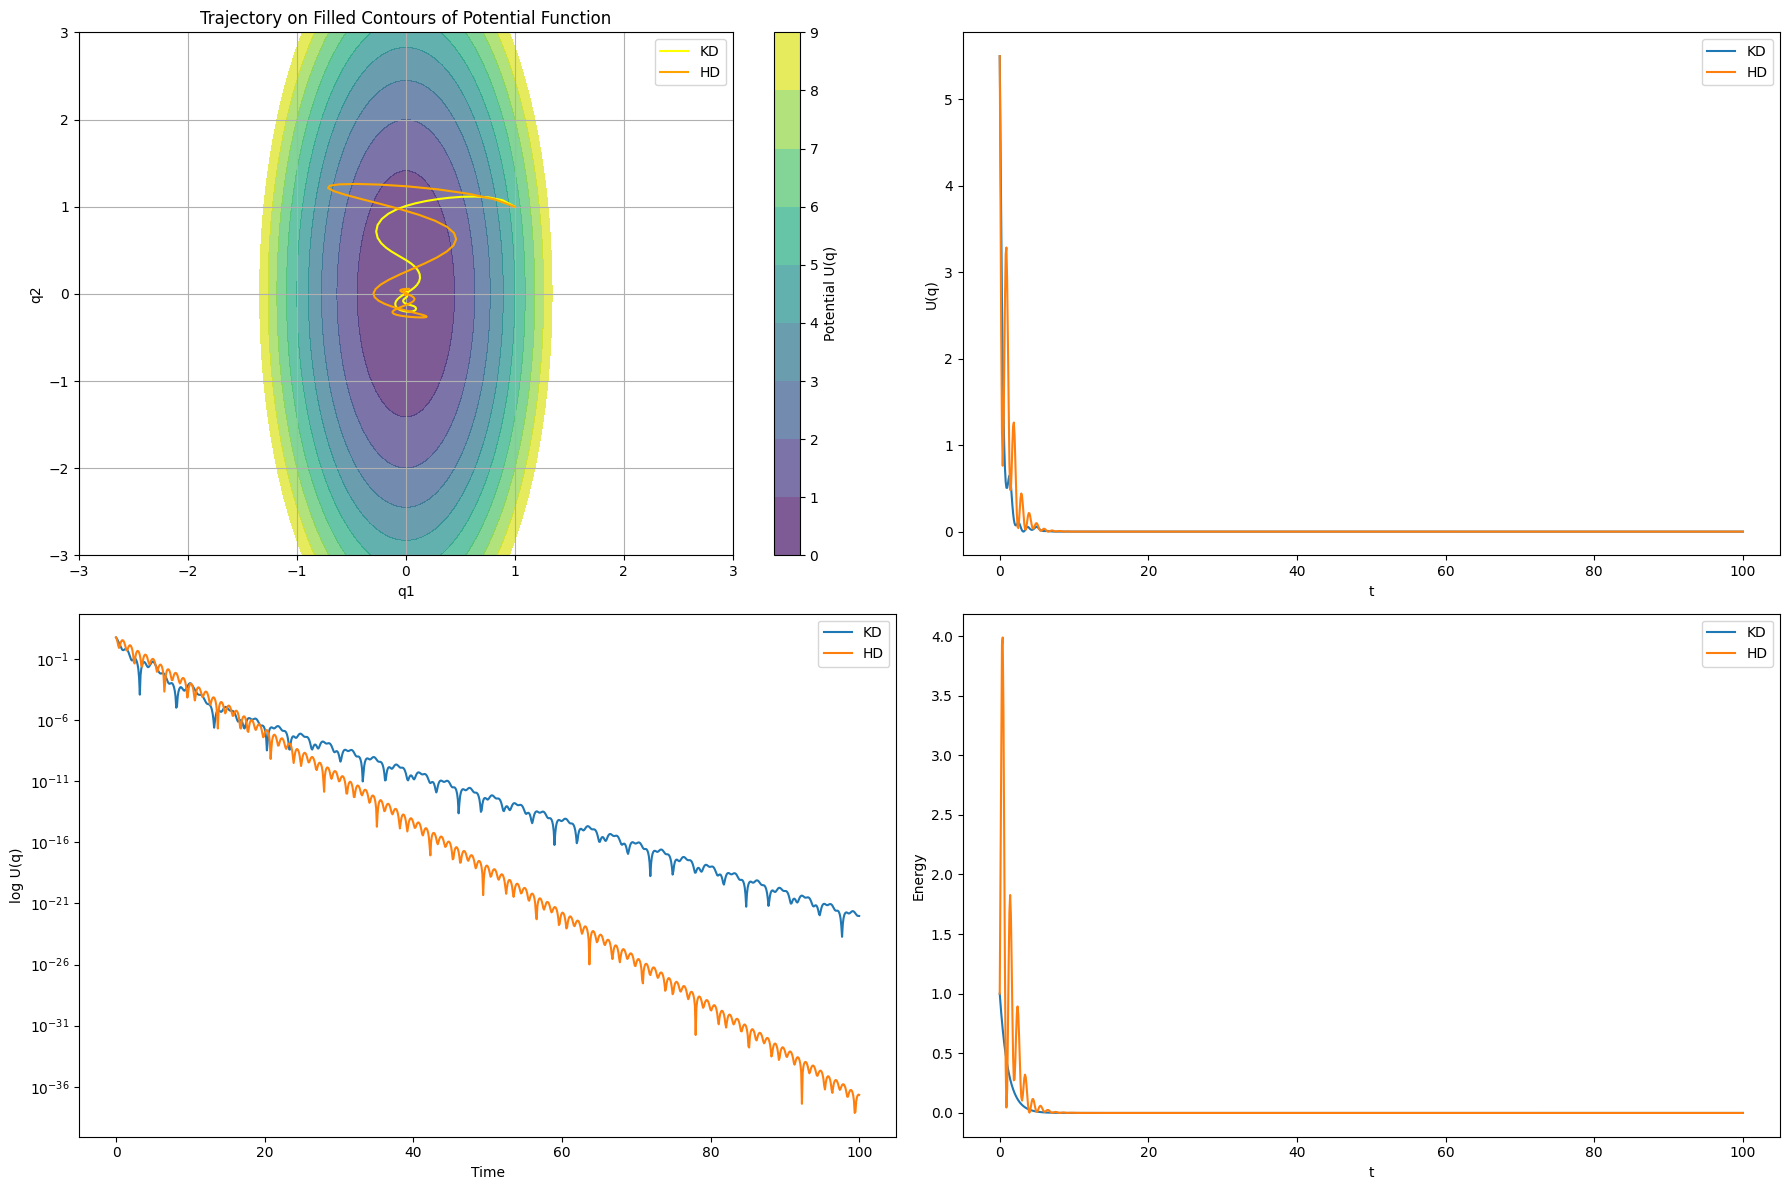

In [287]:
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# Superquadratic Function

In [148]:
U_SQ = lambda x: (x[0] + x[1])**4 + (x[0]/2 - x[1]/2)**4
Force_SQ = lambda x: np.array([
    -4 * (x[0] + x[1])**3 - 2 * (x[0]/2 - x[1]/2)**3,
    -4 * (x[0] + x[1])**3 + 2 * (x[0]/2 - x[1]/2)**3
])

pars = {
    'c0': 1.,
    'gamma': 0.99
}
Ns = 10000
h = 0.1
#q0 = np.array([1., 1.])
#p0 = np.array([-1., 1.])
q0 = np.array([0., -2.])
p0 = np.array([0., np.sqrt(2)])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

U = [U_SQ(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_SQ)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_SQ(q))
    T.append(t)
Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: (X + Y)**4 + (X/2 - Y/2)**4
#plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)
# Large stepsize creates a discretization error leading to a deviation in KE from desired KE.

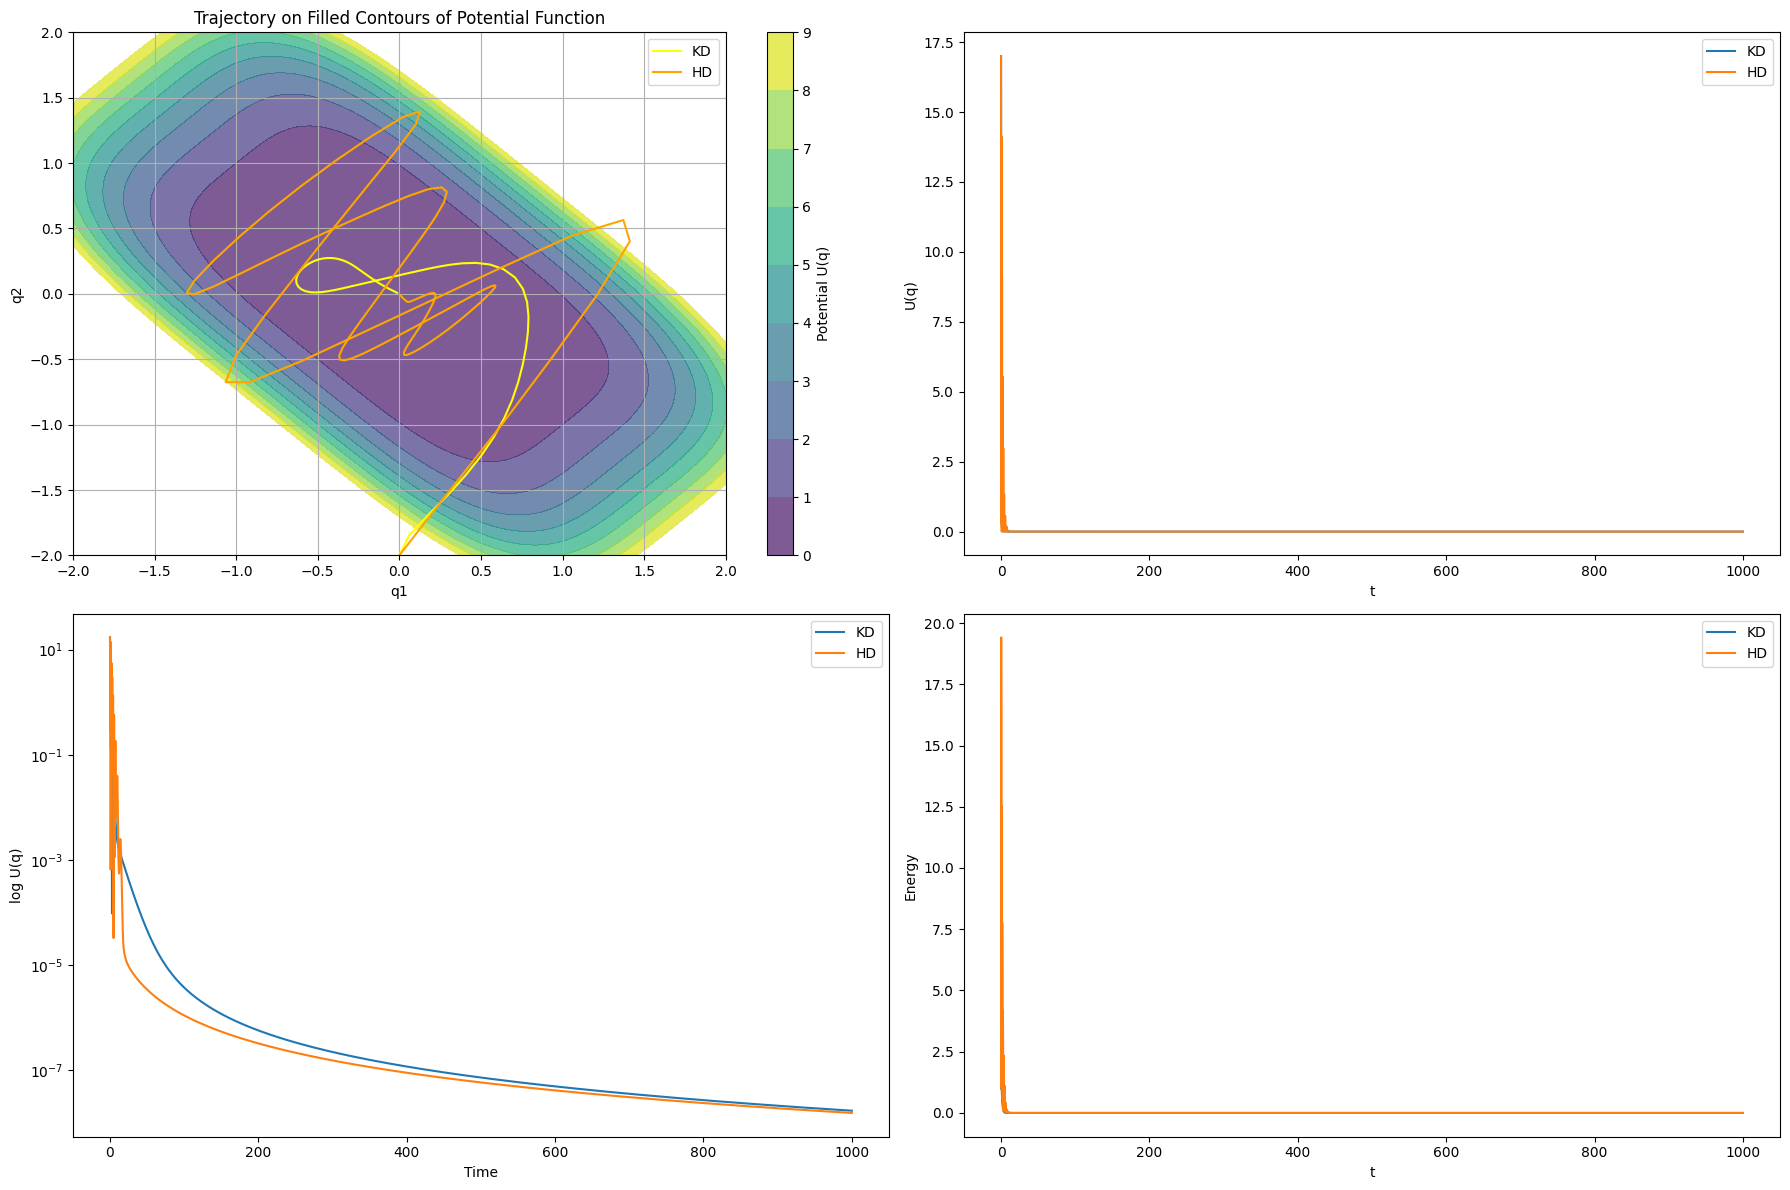

In [149]:
pars = {
    'c0': 0.,
    'gamma':  0.5
}
Ns = 10000
h = 0.1
#q0 = np.array([1., 1.])
#p0 = np.array([-1., 1.])
q0 = np.array([0., -2.])
p0 = np.array([0., np.sqrt(2)])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

U = [U_SQ(q)]
for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_SQ)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_SQ(q))
    T.append(t)
Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=2)

# LR Trap

In [27]:
pars = {
    'c0': 1.,
    'gamma': 0.9
}
Ns = 10000
h = 0.9
q0 = np.array([-1., 0.])
p0 = np.array([1., -1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

coeff = [0.1,0.1,-0.1, -10]
U_TRAP = lambda x: -logit(coeff[0]*expit(coeff[2]*((x[0]-2)**4+x[1]**4)) + coeff[1]*expit(coeff[3]*((x[0]+1)**2+x[1]**2)))#-np.log(0.1*np.exp(-0.1*((x[0]-2)**4+x[1]**4))+ 0.1 * np.exp(-10*((x[0]+1)**2+1*x[1]**2)))
#def Force_TRAP(x):
    #term1 = 0.1 * np.exp(-0.1 * ((x[0] - 2)**4 + x[1]**4))
    #term2 = 0.1 * np.exp(-10 * ((x[0] + 1)**2 + x[1]**2))
    #f_x = term1 + term2
    #dterm1_dx0 = term1 * (-0.4 * (x[0] - 2)**3)
    #dterm1_dx1 = term1 * (-0.4 * x[1]**3)
    #dterm2_dx0 = term2 * (-20 * (x[0] + 1))
    #dterm2_dx1 = term2 * (-20 * x[1])
    #dU_dx0 = -(dterm1_dx0 + dterm2_dx0) / f_x
    #dU_dx1 = -(dterm1_dx1 + dterm2_dx1) / f_x
    #return -np.array([dU_dx0, dU_dx1])

def fx(x,y,pars,eps):
    return (f(x+eps,y,pars)-f(x-eps,y,pars))/(2*eps)

def fy(x,y,pars,eps):
    return (f(x, y+eps,pars)-f(x,y-eps,pars))/(2*eps)
    
def Force_TRAP(x):
    return -np.array([fx(x[0],x[1],coeff,1e-6), fy(x[0],x[1],coeff,1e-6)])

U = [U_TRAP(q)]

for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_TRAP)
    t += h
    Q.append(q)
    P.append(p)
    U.append((U_TRAP(q)-U_TRAP(np.array([2., 0.])))**2) # Note that U is now the squared loss rather than the potential
    T.append(t)

Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: -np.log(0.1*np.exp(-0.1*((X-2)**4+Y**4))+ 0.1 * np.exp(-10*((X+1)**2+1*Y**2)))
#plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)
# Notes: Too small stepsize makes it stuck in local minima. Sensitive to momentum initialization.

In [25]:
pars = {
    'c0': 0.,
    'gamma': 0.9
}
Ns = 10000
h = 0.9
q0 = np.array([-1., 0.])
p0 = np.array([1., -1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_TRAP(q)]

for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_TRAP)
    t += h
    Q.append(q)
    P.append(p)
    U.append((U_TRAP(q)-U_TRAP(np.array([2., 0.])))**2) # Note that U is now the squared loss rather than the potential
    T.append(t)

Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

# Note: Overdamping HD leads to an inability to escape minima. Underdamping to 0.001 seems to almost sample lol.

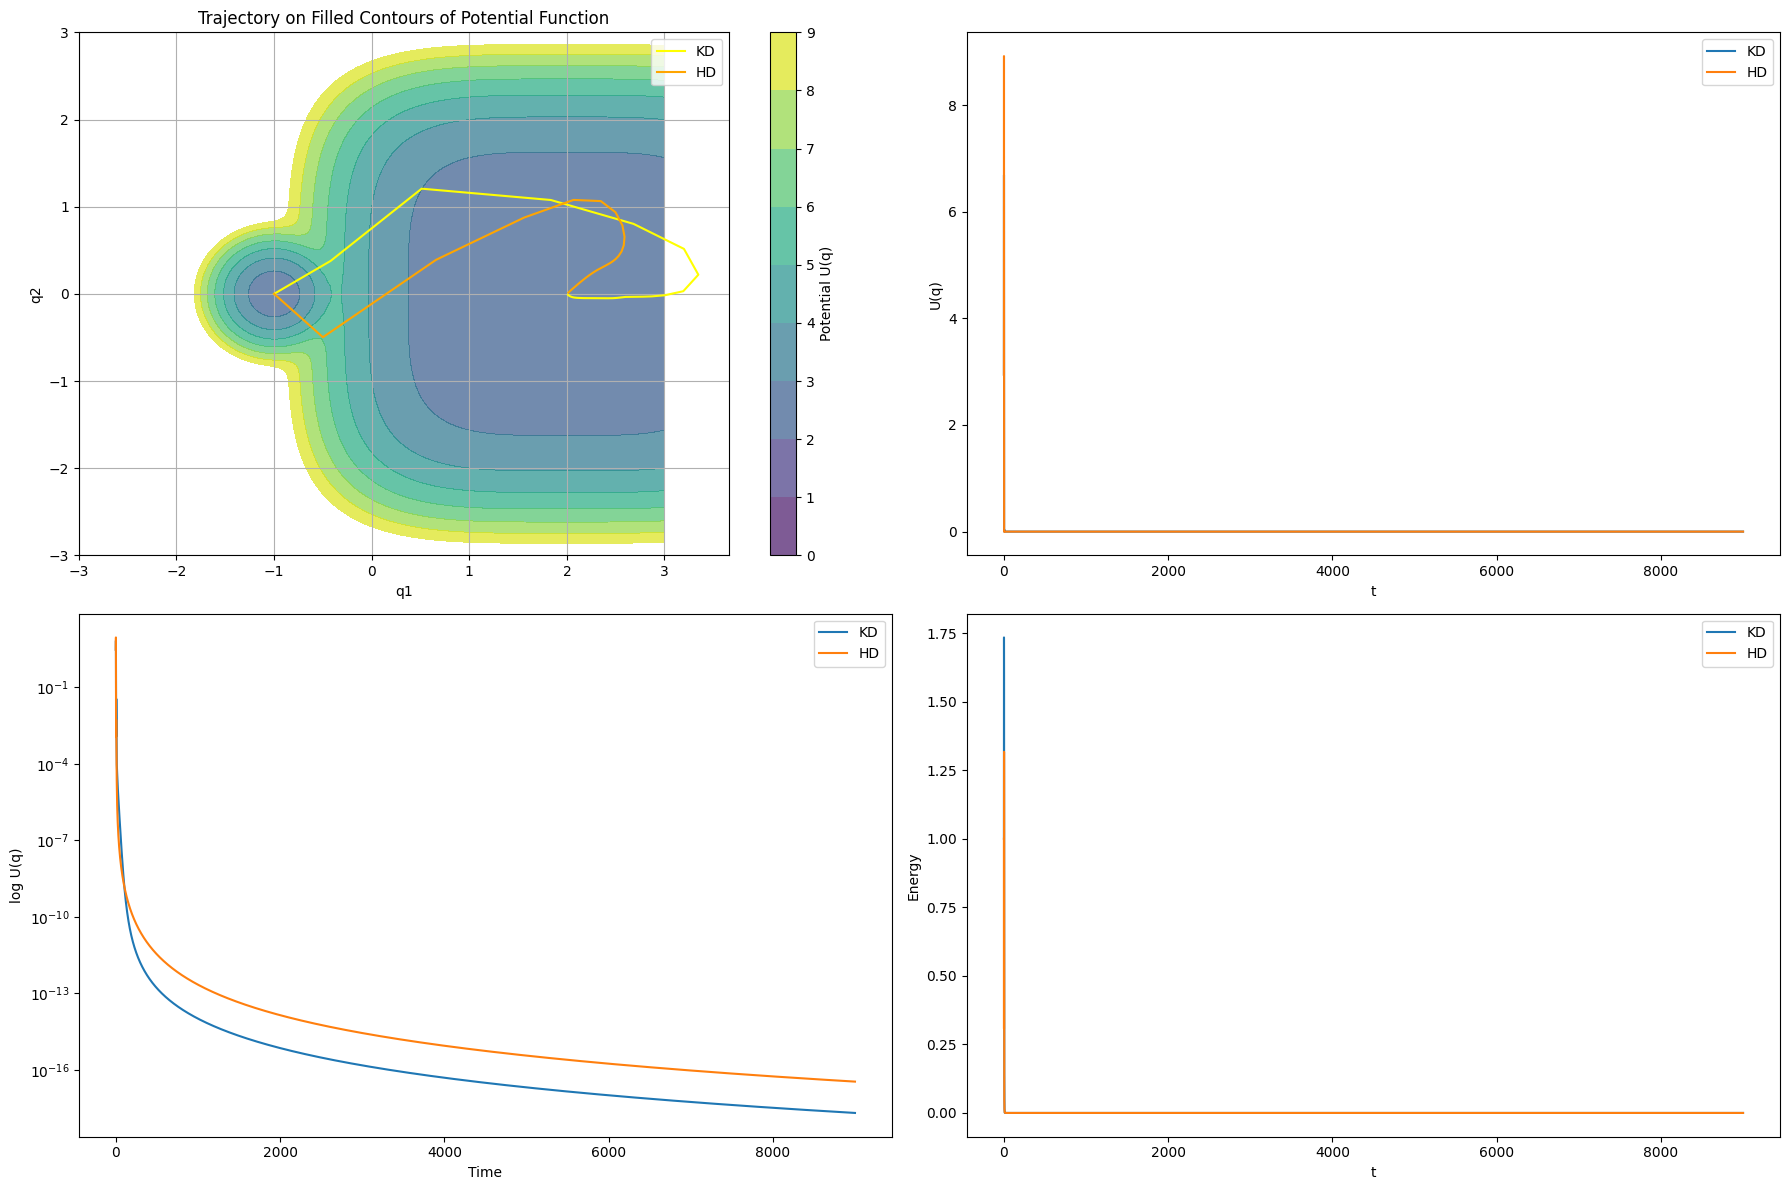

In [28]:
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# Rosenbrock Function

In [8]:
pars = {
    'c0': 1.0,
    'gamma': 0.999
}
Ns = 100000
h = 0.001
q0 = np.array([1.75, 3.])
p0 = np.array([-1., -1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0


def U_rosenbrock(q):
    return 100 * (q[1] - q[0]**2)**2 + (1 - q[0])**2

def FORCE_rosenbrock(q):
    q0, q1 = q[0], q[1]
    dq0 = -400 * q0 * (q1 - q0**2) - 2 * (1 - q0)
    dq1 = 200 * (q1 - q0**2)
    return -np.array([dq0, dq1])

U = [U_rosenbrock(q)]

for n in range(Ns):
    q, p = kd_step(q, p, h, pars, FORCE_rosenbrock)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_rosenbrock(q))
    T.append(t)

Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 100 * (Y - X**2)**2 + (1 - X)**2
#plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)
#Notes: Lots of work needed to tune the optimal gamma given c0=1.

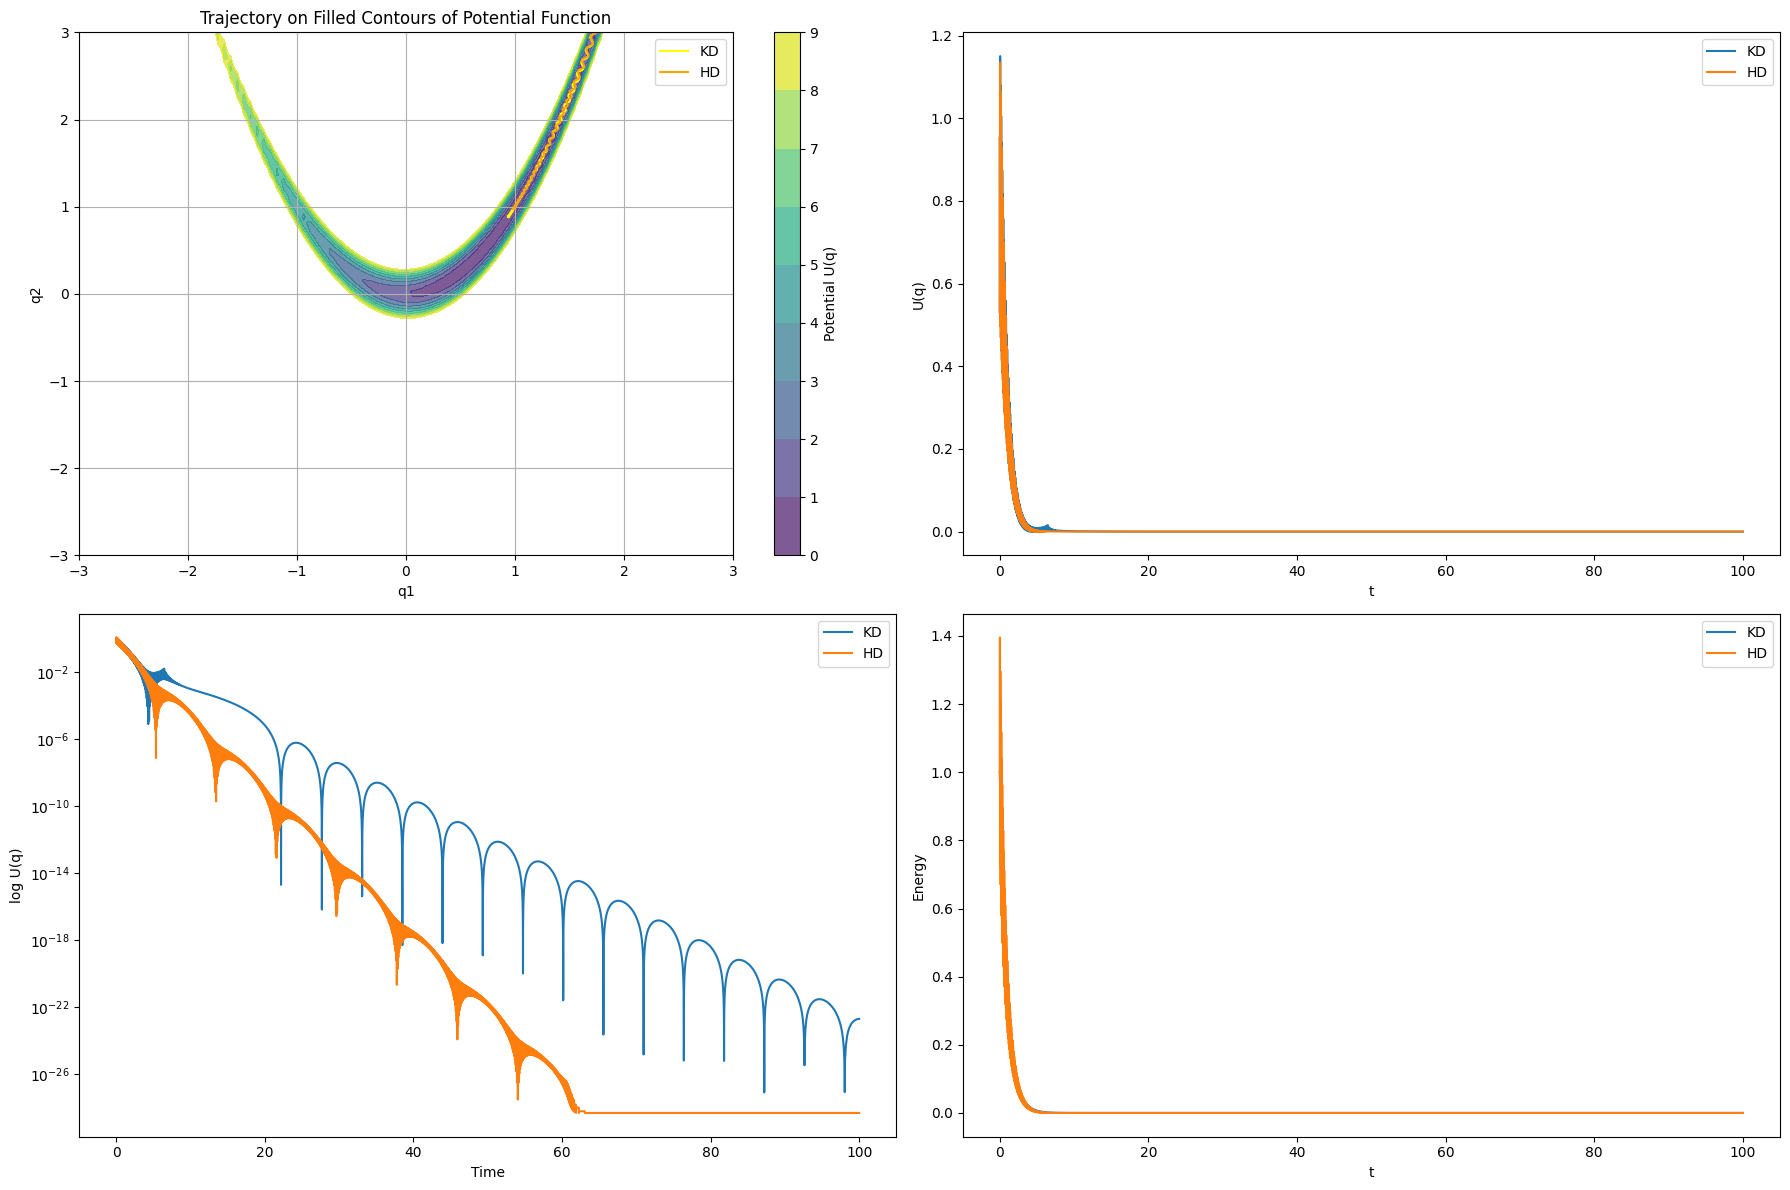

In [113]:
pars = {
    'c0': 0.,
    'gamma': 1.
}
Ns = 100000
h = 0.001
q0 = np.array([1.75, 3.])
p0 = np.array([-1., -1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_rosenbrock(q)]

for n in range(Ns):
    q, p = hd_step(q, p, h, pars, FORCE_rosenbrock)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_rosenbrock(q))
    T.append(t)

Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# Note: Gamma took a lot of tuning to be better than KD.

# High-Dimensional Quadratic Potential

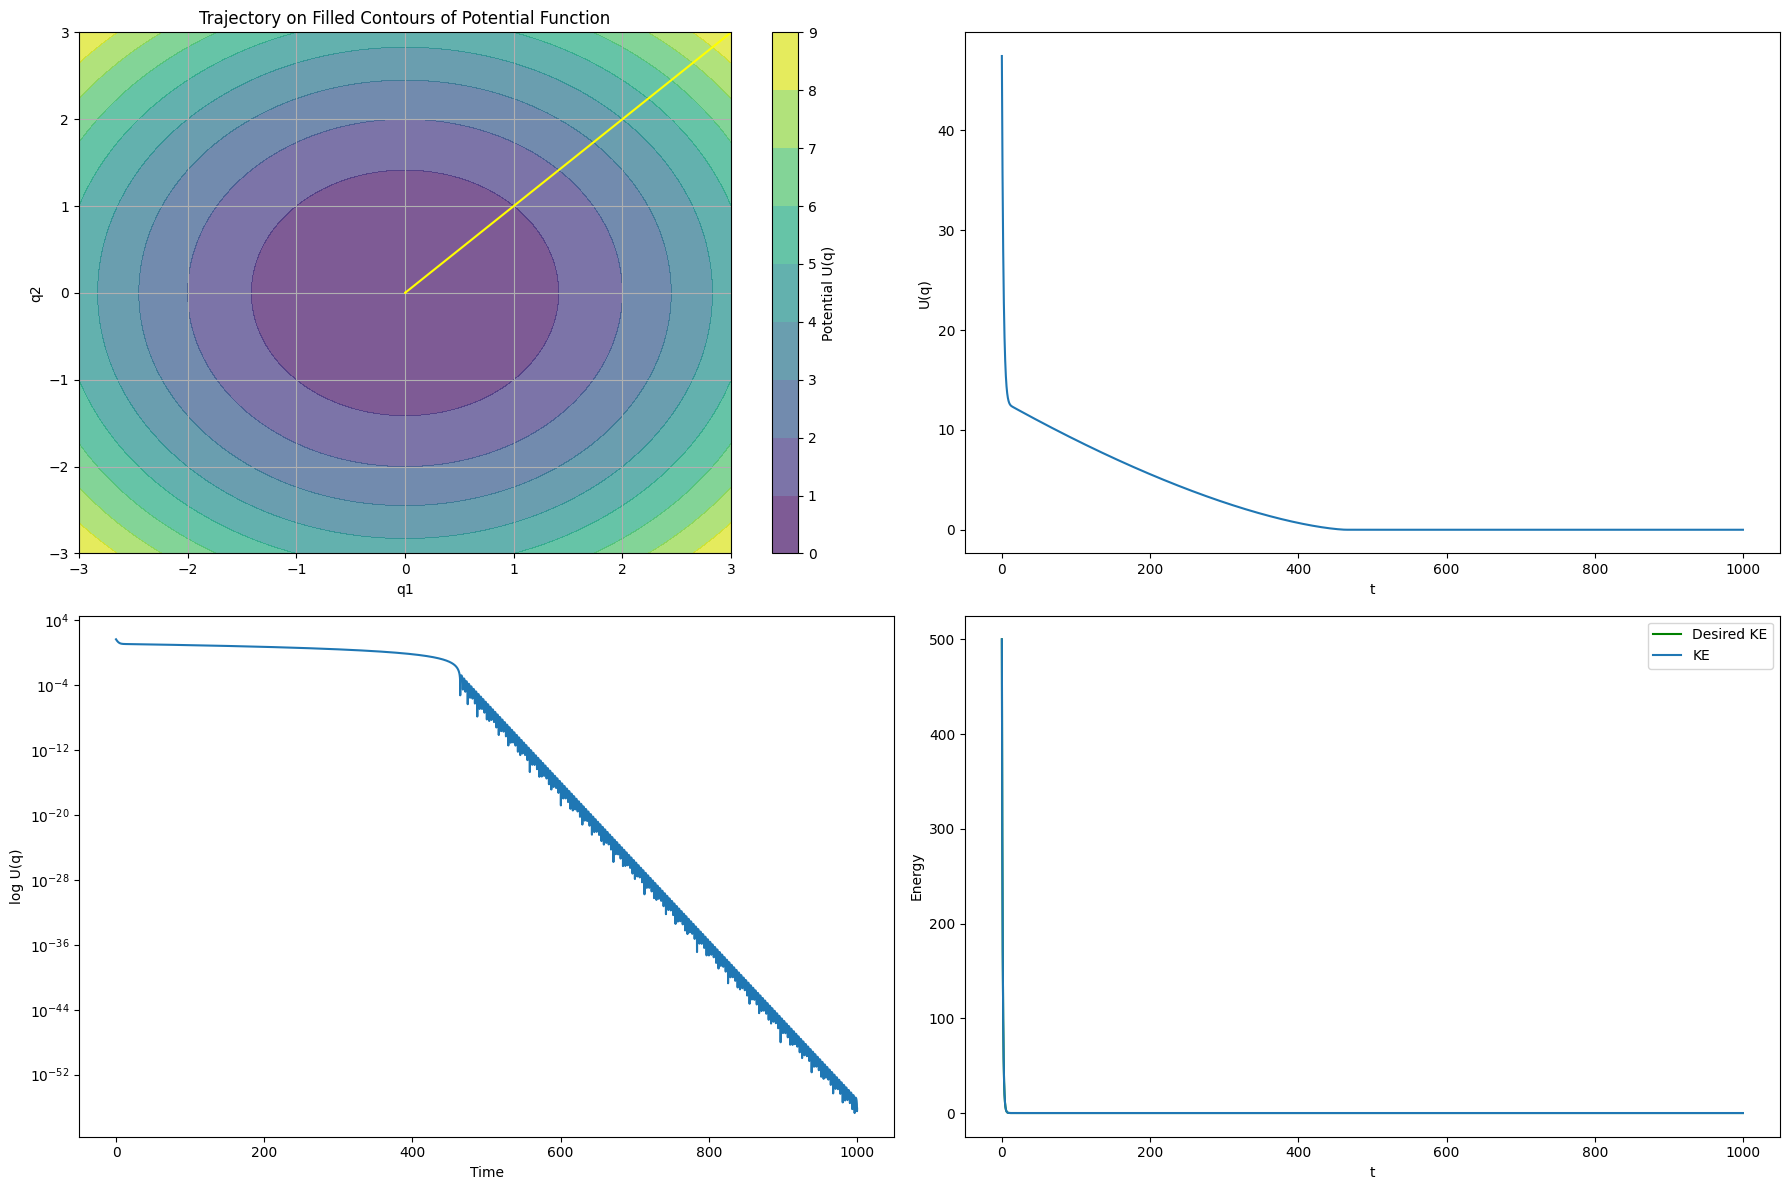

In [171]:
pars = {
    'c0': 500.,
    'gamma': 0.9
}
Ns = 10000
h = 0.1
q0 = np.ones(1000) * 3
p0 = -np.ones(1000)
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * np.linalg.norm(x)
Force_HO = lambda x: -x
U = [U_HO(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (X**2 + Y**2)
plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)

# High-Dimensional Correlated Quadratic Potential

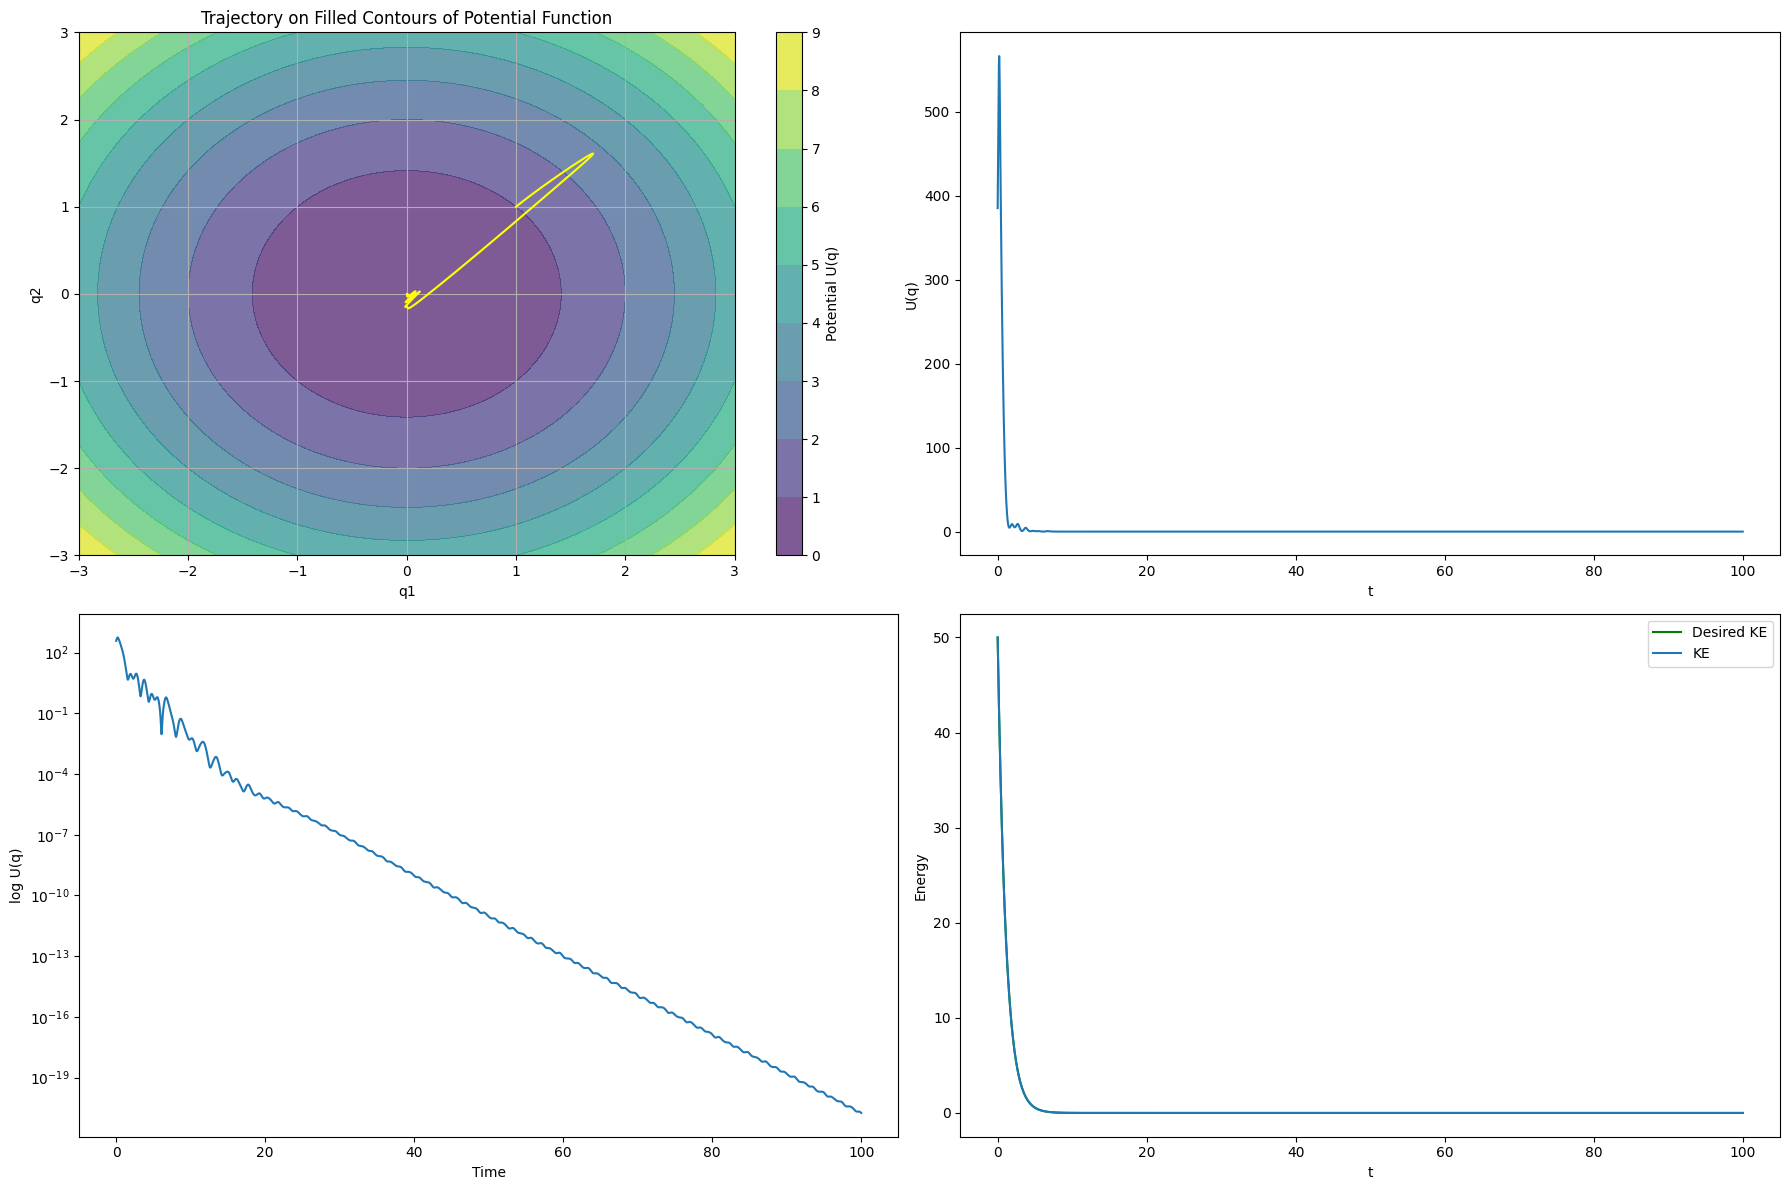

In [313]:
rho = 0.9
d = 50
A = [np.power(rho, np.abs(i-j)) 
            for i in range(1,d+1) for j in range(1,d+1)]
A = np.array(A)
A = A.reshape((d,d))


pars = {
    'c0': 50.,
    'gamma': 0.9
}
Ns = 10000
h = 0.01
q0 = np.ones(d) #np.random.normal(0, 10, d)
p0 = np.ones(d) * np.sqrt(2)
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U_corr = lambda x: 0.5 * np.inner(x,np.inner(A,x))
Force_corr = lambda x: -A.dot(x)
U = [U_corr(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_corr)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_corr(q))
    T.append(t)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (X**2 + Y**2)
plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)

# Questions
 
In the approach to the minimum

i. do we lose any generalisability

ii. do we see similar convergence rate locally to plain momentum stochastic gradient descent

iii. do we see improved stability at large stepsize compared to popular schemes for momentum SGD - At the moment, it does not even converge for larger stepsizes, probably due to the RK4 error.

iv. is it affine invariant?

v. What is the integrator error?

vi. What is the convergence rate precisely?

vii. How does gamma, p0, and c0 impact convergence rate and error?
